In [1]:
import pandas as pd
from tensorflow import keras
import string
import numpy as np
import spacy
import itertools

from spacy.lang.en.stop_words import STOP_WORDS

In [2]:
df = pd.read_json(open("final_dataset/merged_dset.json", "r", encoding="utf8"))
df = df.drop(['url'], axis=1)

In [3]:
# count quantity of entries by theme
theme_entry_count = {}
for entry in df.themes:
    for theme in entry:
        if theme in theme_entry_count.keys():
            theme_entry_count[theme] += 1
        else:
            theme_entry_count[theme] = 1

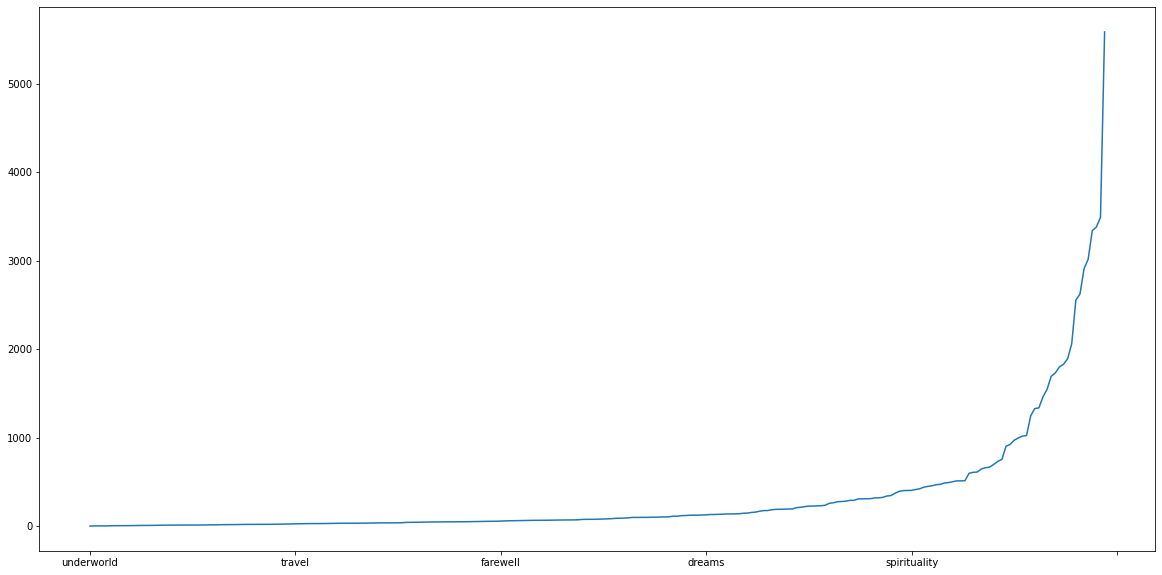

In [4]:
# plot themes distribution
theme_entry_count = pd.Series(theme_entry_count).sort_values()
theme_entry_count.plot(figsize=(20, 10))

In [5]:
# remove the least frequent themes
themes_to_remove = theme_entry_count[theme_entry_count<50]

def remove_themes(themes): # TODO
    result = []
    for theme in themes:
        if theme not in themes_to_remove:
            result.append(theme)
    return result

df.themes = df.themes.apply(remove_themes)

# remove entries without theme
df = df[df['themes'].str.len() != 0]

In [6]:
# get a set of themes
themes = set(itertools.chain.from_iterable(df.themes))

# themes encoding
themes = set(itertools.chain.from_iterable(df.themes))
themes = {list(themes)[i]: i for i in range(len(themes))}

def encode_themes(available_themes):
    result = [0,] * len(themes)
    for i in available_themes:
        result[themes[i]] = 1
    return result

df.themes = df.themes.apply(encode_themes)

In [7]:
# authors encoding
authors = df.author.unique()
authors = {list(authors)[i]: i for i in range(len(authors))}
df.author = [authors[row['author']]for index, row in df.iterrows()]

In [8]:
#  Remove punctuation
table = str.maketrans('', '', string.punctuation)
df['text'] = [row['text'].translate(table) for index, row in df.iterrows()]
df['title'] = [row['title'].translate(table) for index, row in df.iterrows()]
#  Remove stopwords
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in STOP_WORDS))

In [9]:
#  Lemmatization
nlp = spacy.load("en_core_web_sm")
lemmatizer = nlp.get_pipe("lemmatizer")

df['title'] = [
                [token.lemma_ for token in nlp(row['title'])]
                for index, row in df.iterrows()
             ]
df['text'] = [
                [token.lemma_ for token in nlp(row['text'])]
                for index, row in df.iterrows()
             ]

In [10]:
max_features=10000

# tokenization
tok = keras.preprocessing.text.Tokenizer(
    num_words=max_features,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True)  
tok.fit_on_texts(df['text'])

In [11]:
# text to number sequences
df['text'] = tok.texts_to_sequences(df['text'])
df['title'] = tok.texts_to_sequences(df['title'])

In [12]:
df.head()

,title,author,year,text,themes
0,"[45, 4, 139, 908]",0,2002,"[2, 2361, 1096, 5, 2361, 297, 9670, 995, 407, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,[2892],1,2002,"[1, 97, 107, 4468, 3, 148, 294, 32, 1426, 8501...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[208],2,2002,"[107, 19, 716, 21, 1450, 329, 239, 162, 429, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[1220, 40, 115, 2037, 16, 2377]",3,2002,"[329, 304, 18, 72, 8, 1, 8, 1, 44, 1337, 1, 20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[263, 1220]",4,2002,"[9, 644, 75, 143, 537, 197, 676, 179, 106, 43,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
# export encoded data
data = df.to_json()
with open('../data/2data.json', 'w') as f:
    f.write(data)